# Fitting Hurst parameter to capture mean-reversion or trending behaviour in time series. Application to UST yield curve.


In [1]:
import numpy as np
from hurst_fitting import *
from datetime import datetime
import quandl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
LAGS = 10
ONE_PCT = 1e-2

## UST yield curve data 2017-2019

In [5]:
START_DATE = datetime(2017,1,18)
END_DATE = datetime(2019,1,14)

dfs = quandl.get("FED/SVENY", authtoken="Mn11_JRws2o-D5E9CGzc")*ONE_PCT
dfs = dfs[dfs.index>=START_DATE]
dfs = dfs[dfs.index<=END_DATE]
new_names = [s.replace('SVENY', '') + 'Y' for s in dfs.columns]
dfs.rename(columns=dict(zip(dfs.columns, new_names)), inplace=True)

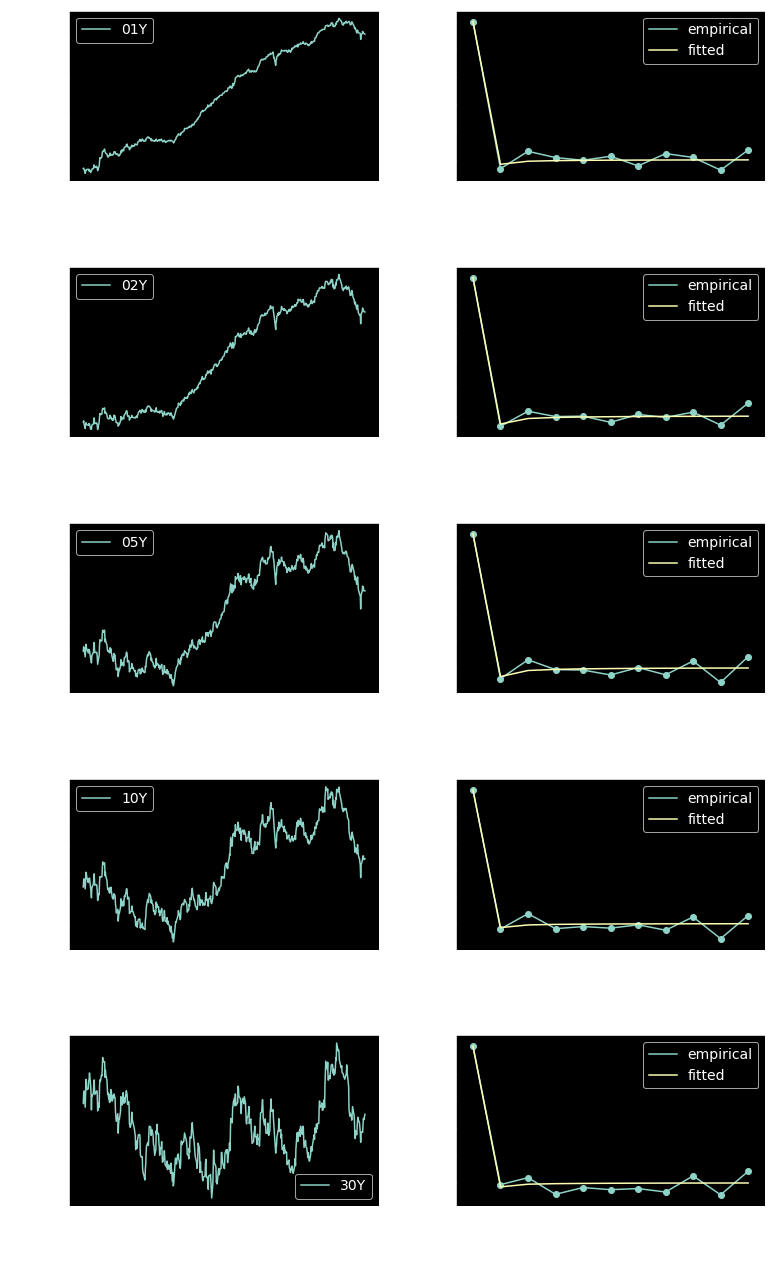

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=2)

tenors = ['01Y', '02Y', '05Y', '10Y', '30Y']

fitter = Hurst_fitter(n_lags=LAGS)

for i, ax_row in enumerate(axes):
    tenor = tenors[i]
    df = dfs[tenor]
    
    # initialize Hurst fitter
    fitter.df = df
    H_fit = fitter.fit()
    
    ax = ax_row[0]
    df.plot(kind='line', ax=ax)
    ax.set_ylabel('spot')
    ax.legend()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

    ax = ax_row[1]
    ys = acf(fitter.df_inc, nlags=LAGS)
    ys_fit = fitter.autocorr_frac_noise_range(H_fit)
    ax.plot(fitter.lag_range, ys, label='empirical')
    ax.scatter(fitter.lag_range, ys, marker='o')
    ax.plot(fitter.lag_range, ys_fit, label='fitted')
        
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.set_xlabel('lag\ntenor: {}\nH={:.3f}'.format(tenor, H_fit))
    ax.set_ylabel('autocorrelogram')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## UST yield curve data 1961-1971

In [7]:
START_DATE = datetime(1961,6,14)
END_DATE = datetime(1971,6,14)

dfs = quandl.get("FED/SVENY", authtoken="Mn11_JRws2o-D5E9CGzc")*ONE_PCT
dfs = dfs[dfs.index>=START_DATE]
dfs = dfs[dfs.index<=END_DATE]
new_names = [s.replace('SVENY', '') + 'Y' for s in dfs.columns]
dfs.rename(columns=dict(zip(dfs.columns, new_names)), inplace=True)

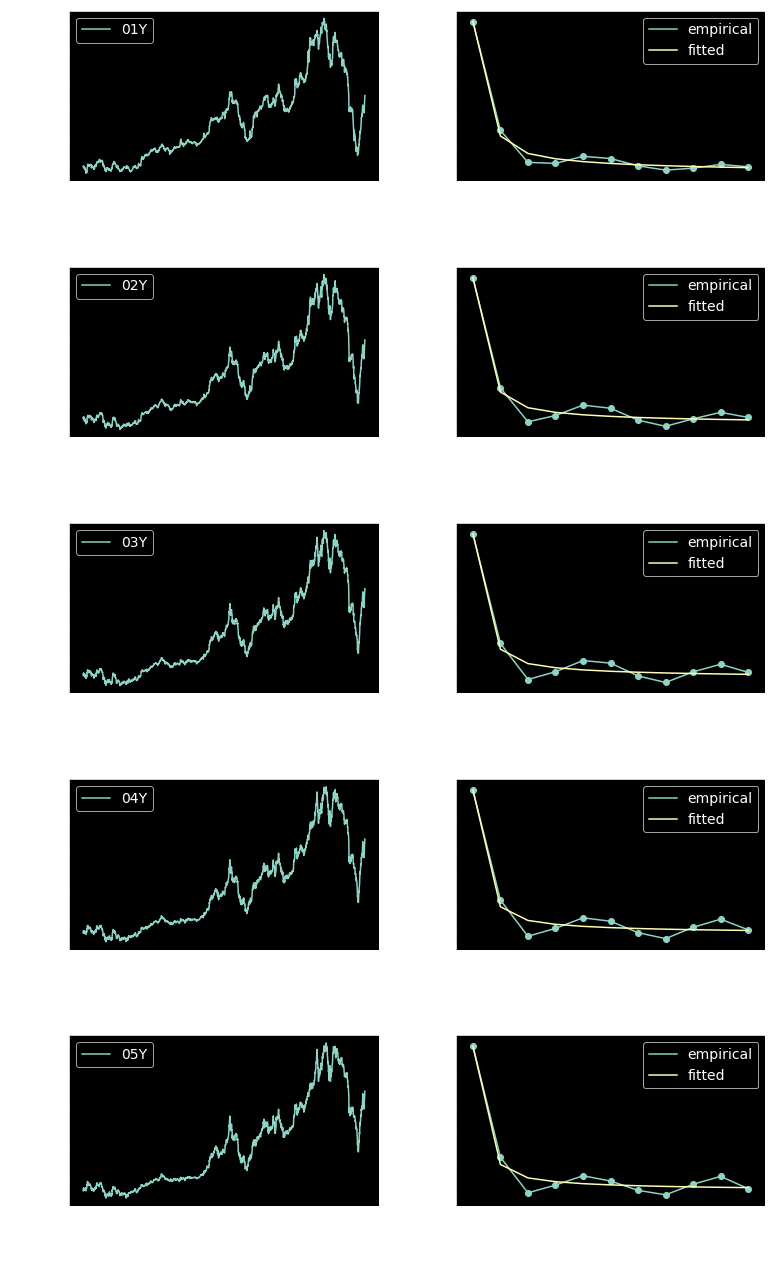

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=2)

tenors = ['01Y', '02Y', '03Y', '04Y', '05Y']

fitter = Hurst_fitter(n_lags=LAGS)

for i, ax_row in enumerate(axes):
    tenor = tenors[i]
    df = dfs[tenor]
    
    # initialize Hurst fitter
    fitter.df = df
    H_fit = fitter.fit()
    
    ax = ax_row[0]
    df.plot(kind='line', ax=ax)
    ax.set_ylabel('spot')
    ax.legend()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

    ax = ax_row[1]
    ys = acf(fitter.df_inc, nlags=LAGS)
    ys_fit = fitter.autocorr_frac_noise_range(H_fit)
    ax.plot(fitter.lag_range, ys, label='empirical')
    ax.scatter(fitter.lag_range, ys, marker='o')
    ax.plot(fitter.lag_range, ys_fit, label='fitted')
        
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.set_xlabel('lag\ntenor: {}\nH={:.3f}'.format(tenor, H_fit))
    ax.set_ylabel('autocorrelogram')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Dynamics of Hurst parameter
Calibrate the Hurst parameter on a rolling window.

Values significantly higher than $0.5$ are hints of a trend, conversely values significantly less than $0.5$ describe periods of mean-reversion.

In [9]:
df_yc = quandl.get("FED/SVENY", authtoken="Mn11_JRws2o-D5E9CGzc")*ONE_PCT
new_names = [s.replace('SVENY', '') + 'Y' for s in df_yc.columns]
df_yc.rename(columns=dict(zip(df_yc.columns, new_names)), inplace=True)

In [10]:
WINDOW = 300

In [11]:
fitter = Hurst_fitter(n_lags=LAGS)

In [12]:
def fit_apply(x):
    fitter.df = x
    return fitter.fit()

In [13]:
#df_hurst = dfs.rolling(WINDOW).apply(fit_apply, raw=False).iloc[WINDOW:]
xl = pd.ExcelFile('hurst_yc_ust.xls')
df_hurst = pd.read_excel(xl, sheet_name = 'Hurst')
df_hurst.set_index(['Date'], inplace=True)

## All history

Long-term regime switch from $H\approx 0.6$ to $H\approx 0.5$ as the UST market gets increasingly (statistically) arbitrage-free.

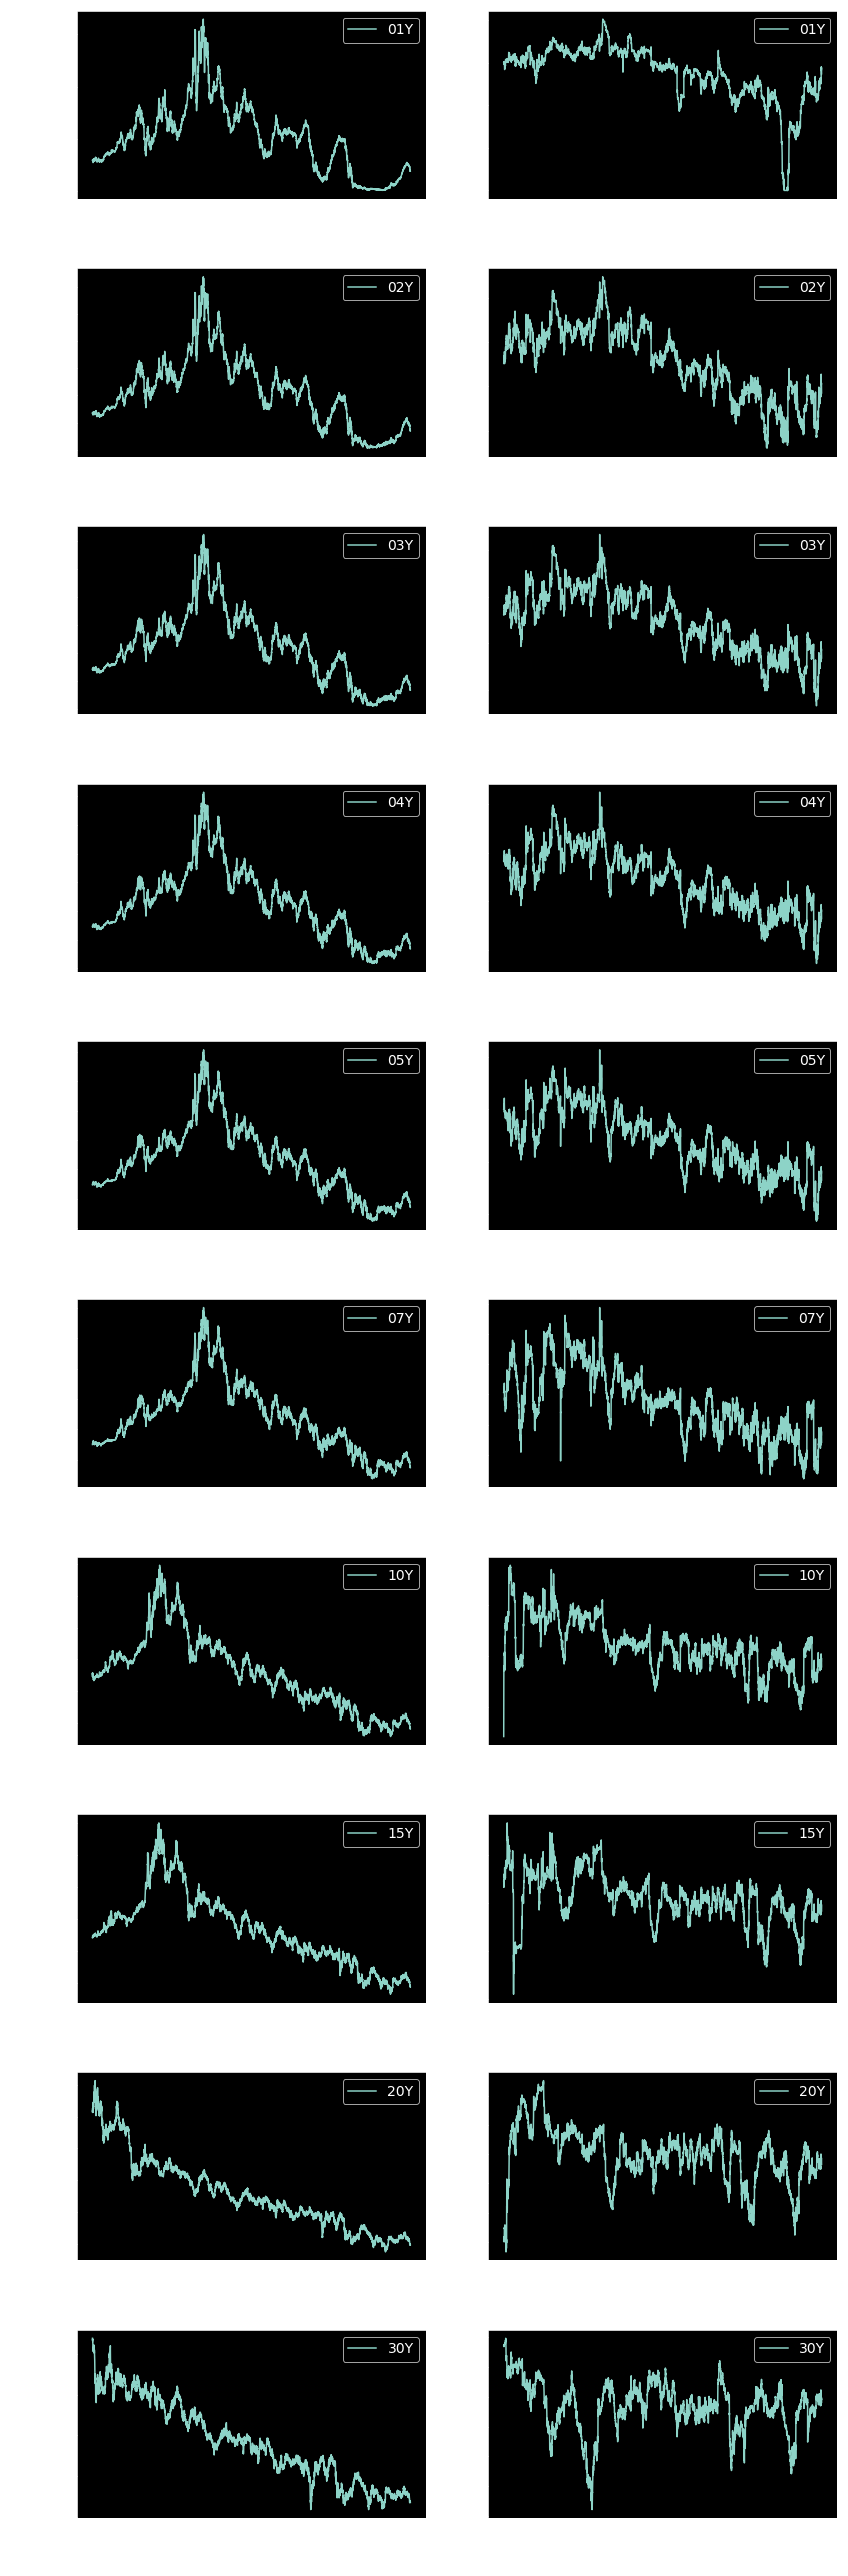

In [14]:
fig, axes = plt.subplots(figsize=(12, 36), nrows=10, ncols=2)

tenors = ['01Y', '02Y', '03Y', '04Y', '05Y', '07Y', '10Y', '15Y', '20Y', '30Y']

fitter = Hurst_fitter(n_lags=LAGS)

for i, ax_row in enumerate(axes):
    tenor = tenors[i]
    
    ax = ax_row[0]
    df = df_yc[tenor]
    df.plot(kind='line', ax=ax)
    ax.set_ylabel('yield')
    ax.legend()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    
    ax = ax_row[1]
    df = df_hurst[tenor]
    df.plot(kind='line', ax=ax)
    ax.set_ylabel('Hurst parameter')
    ax.legend()

plt.tight_layout()
plt.show()

## Last 10 years

In [15]:
START_DATE = datetime(2011,1,18)
END_DATE = datetime(2019,1,14)

df_hurst = df_hurst[df_hurst.index>=START_DATE]
df_hurst = df_hurst[df_hurst.index<=END_DATE]

df_yc = df_yc[df_yc.index>=START_DATE]
df_yc = df_yc[df_yc.index<=END_DATE]

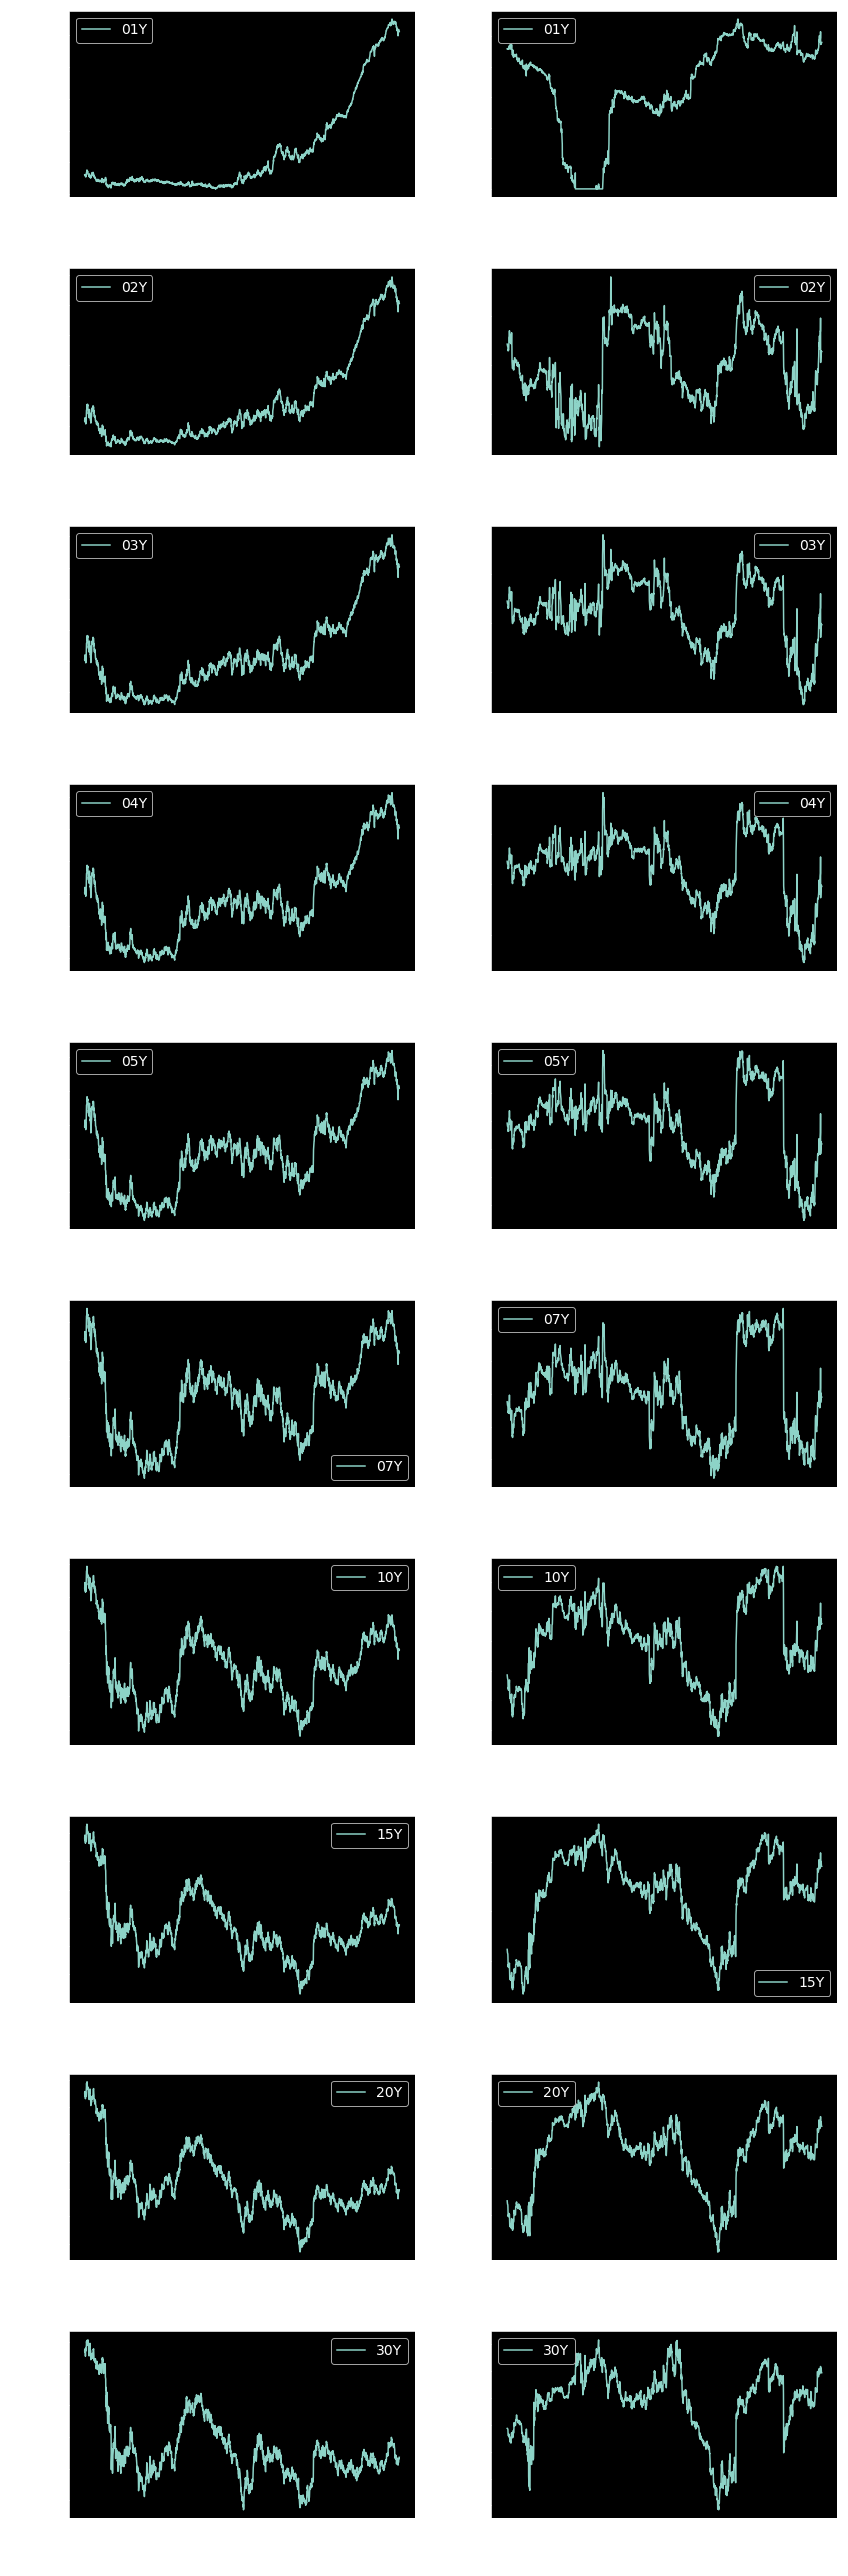

In [16]:
fig, axes = plt.subplots(figsize=(12, 36), nrows=10, ncols=2)

tenors = ['01Y', '02Y', '03Y', '04Y', '05Y', '07Y', '10Y', '15Y', '20Y', '30Y']

fitter = Hurst_fitter(n_lags=LAGS)

for i, ax_row in enumerate(axes):
    tenor = tenors[i]
    
    ax = ax_row[0]
    df = df_yc[tenor]
    df.plot(kind='line', ax=ax)
    ax.set_ylabel('yield')
    ax.legend()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    
    ax = ax_row[1]
    df = df_hurst[tenor]
    df.plot(kind='line', ax=ax)
    ax.set_ylabel('Hurst parameter')
    ax.legend()

plt.tight_layout()
plt.show()

In [17]:
#df_hurst.to_excel('hurst_yc_ust.xls', sheet_name='Hurst')